# Using a random forest to classify Palmer Penguins 🐧 by species

[Palmer Penguins](https://allisonhorst.github.io/palmerpenguins/) is a dataset consisting of penguin measurements from the Palmer Archipelago in Antarctica. This notebook demonstrates the process to classify this data to species ([Adelie](https://www.antarctica.gov.au/about-antarctica/animals/penguins/adelie-penguin/), [Chinstrap](https://www.antarctica.gov.au/about-antarctica/animals/penguins/chinstrap-penguin/), or [Gentoo](https://www.antarctica.gov.au/about-antarctica/animals/penguins/gentoo-penguin/)) based on bill length, bill depth, flipper length, and body mass using a random forest model.

[![Latest release](https://badgen.net/github/release/Naereen/Strapdown.js)](https://github.com/eabarnes1010/course_objective_analysis/tree/main/code)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/eabarnes1010/course_objective_analysis/blob/main/code/random_forest_palmerpenguins.ipynb)


*    Example by [Daniel Hueholt](https://hueholt.earth), PhD student at Colorado State University (CSU): [see his original notebook here](https://github.com/dmhuehol/palmerpenguins-classifiers/blob/main/rf_class_palmerpenguins.ipynb)
*    Borrows format and some functions from the [CSU Machine Learning Tutorial](https://zenodo.org/record/6686879) including code originally by Prof. Elizabeth Barnes, Zaibeth Carlo Frontera, Aaron Hill, Daniel Hueholt, Wei-Ting Hsiao, and Jamin Rader
*    For details on Palmer Penguins and cute penguin art, see the official [Palmer Penguins page at GitHub](https://allisonhorst.github.io/palmerpenguins/) or [Horst et al. 2022](doi.org/10.32614/RJ-2022-020)

* Further adapted by: Prof. Elizabeth Barnes for ATS 655 and ATS 780A7 at Colorado State University


# 0. Set Up Environments

In [1]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
print('IN_COLAB = ' + str(IN_COLAB))

IN_COLAB = False


In [2]:
if IN_COLAB:
    !pip install palmerpenguins

from graphviz import Source # To plot trees
import matplotlib.pyplot as plt
from palmerpenguins import load_penguins # Dataset
import numpy as np
import pandas as pd # For confusion matrix
import pydot
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.tree import export_graphviz
import sys

print(f"python version = {sys.version}")
print(f"scikit-learn version = {sklearn.__version__}")

python version = 3.9.16 | packaged by conda-forge | (main, Feb  1 2023, 21:38:11) 
[Clang 14.0.6 ]
scikit-learn version = 1.2.1


In [3]:
# Make the path of your own Google Drive accessible to save a figure
if IN_COLAB:
    try:
        from google.colab import drive
        drive.mount('/content/drive', force_remount=True)
        local_path = '/content/drive/My Drive/Colab Notebooks/'
    except:
        local_path = './'
else:
    local_path = '../figures/'

# 1. Load and look at data

In [4]:
X,y = load_penguins(return_X_y=True, drop_na=True) #drop_na removes observations with NaN values

print('--- FEATURES ---')
print(X.head())
feature_names = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']

print('\n--- LABELS ---')
print(y.head())

print('\n--- UNIQUE LABELS / CLASSES ---')
classes = np.unique(y.values) # These are the penguin species
print(classes)

--- FEATURES ---
   bill_length_mm  bill_depth_mm  flipper_length_mm  body_mass_g
0            39.1           18.7              181.0       3750.0
1            39.5           17.4              186.0       3800.0
2            40.3           18.0              195.0       3250.0
4            36.7           19.3              193.0       3450.0
5            39.3           20.6              190.0       3650.0

--- LABELS ---
0    Adelie
1    Adelie
2    Adelie
4    Adelie
5    Adelie
Name: species, dtype: object

--- UNIQUE LABELS / CLASSES ---
['Adelie' 'Chinstrap' 'Gentoo']


We use the features (called `X`) to classify the data by target/label (called `y`). With this data, our targets/labels are the species of each penguin, while our features are physical measurements from each penguin.

We need to split the data into **training, validation, and testing datasets**. With Earth science data, we often need to carefully consider the method we use for this in order to prevent "data leakage" between these data splits. With penguins, this isn't a concern--so we can just use Scikit's default method to do this!

In [5]:
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=100,
                                                          random_state=13) # first reserve the held-back testing data
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=100,
                                                       random_state=13) # then reserve the validation data (for hyperparameter tuning)
 
# Commented lines below are to look at the split data
# print('--- TRAINING ---')
# print(X_train.head(), y_train.head())
# print('--- VALIDATION ---')
# print(X_val.head(), y_val.head())
# print('--- HELD-BACK TESTING --- ')
# print(X_test.head(), y_test.head())

We now have the following variables:


*   `X_train` and `y_train`: features and labels used for training
*   `X_val` and `y_val`: features and labels used for validation (hyperparameter tuning)
*   `X_test` and `y_test`: features and labels held back for testing



Now we are ready to set up the random forest model!

# 2. Set up and run the random forest

We define the tunable parameters (hyperparameters) that we'll use for the model. We put these values in a dictionary so they can easily be accessed and modified for future experiments. Note these parameters give good performance because they have already been tuned for this demo!

In [6]:
### MODIFY HYPERPARAMETERS WITHIN THIS CELL
fd = {
    "tree_number": 15,    # number of trees to "average" together to create a random forest
    "tree_depth": 5,      # maximum depth allowed for each tree
    "node_split": 20,     # minimum number of training samples needed to split a node
    "leaf_samples": 1,    # minimum number of training samples required to make a leaf node
    "criterion": 'gini',  # information gain metric, 'gini' or 'entropy'
    "bootstrap": False,   # whether to perform "bagging=bootstrap aggregating" or not
    "max_samples": None,  # number of samples to grab when training each tree IF bootstrap=True, otherwise None 
    "random_state": 13    # set random state for reproducibility
}

### Default values are retained below for reference
# fd = {
#     "tree_number": 15,    # number of trees to "average" together to create a random forest
#     "tree_depth": 5,      # maximum depth allowed for each tree
#     "node_split": 20,     # minimum number of training samples needed to split a node
#     "leaf_samples": 1,    # minimum number of training samples required to make a leaf node
#     "criterion": 'gini',  # information gain metric, 'gini' or 'entropy'
#     "bootstrap": False,   # whether to perform "bagging=bootstrap aggregating" or not
#     "max_samples": None,  # number of samples to grab when training each tree IF bootstrap=True, otherwise None 
#     "random_state": 13    # set random state for reproducibility
# }


We set up the random forest classifier to use the hyperparameters we just specified.



In [7]:
forest = RandomForestClassifier(
                           n_estimators = fd["tree_number"],
                           random_state = fd["random_state"],
                           min_samples_split = fd["node_split"],
                           min_samples_leaf = fd["leaf_samples"],
                           criterion = fd["criterion"],
                           max_depth = fd["tree_depth"],
                           bootstrap = fd["bootstrap"],
                           max_samples = fd["max_samples"])

Now we are ready to train the random forest to identify the penguins from the measurements in our training dataset!

In [8]:
forest.fit(X_train, y_train) # Runs the forest classifier
y_pred = forest.predict(X_train)

Let's check how well we did on the training data using the accuracy score and a confusion matrix.

training accuracy:  99.0 %


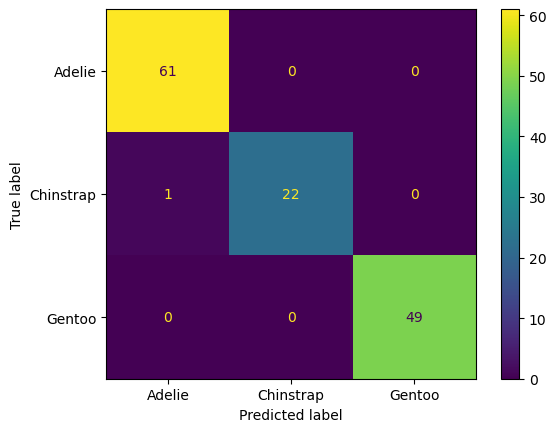

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

acc = metrics.accuracy_score(y_train, y_pred)
print("training accuracy: ", np.around(acc*100), '%')

cm = confusion_matrix(y_train, y_pred, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

disp.plot()
plt.show()

Now let's try the validation data, to make sure our model applies to data it hasn't seen before.

In [10]:
y_pred_val = forest.predict(X_val)

acc = metrics.accuracy_score(y_val, y_pred_val)
print("validation accuracy: ", np.around(acc*100), '%')
confusion_matrix(y_val, y_pred_val)

validation accuracy:  95.0 %


array([[35,  2,  1],
       [ 2, 22,  0],
       [ 0,  0, 38]])

Continue tuning the hyperparameters until you're happy with the validation accuracy. Once you are, you can once (and only once!) apply your model on the testing data. Before we do that, it's useful to try to understand how the model makes its decisions. This helps you to check whether it's overfitting, not successfully making decisions, or is ready to roll!

# 3. Explainability and interpretability

## 3.1. Look at an individual tree

Random forests are made up of individual decision trees. You can get an idea of how the model is making its decisions by looking at these trees. Simple decision trees are easily *interpretable*, that is, humans can easily understand the method by which the model makes its decisions.

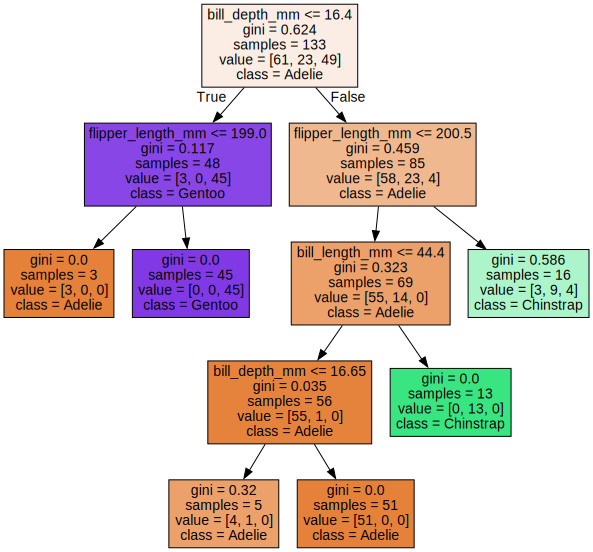

In [11]:
from graphviz import Source

fig_savename = 'rf_penguin_tree'
tree_to_plot = 0 # Enter the value of the tree that you want to see!

tree = forest[tree_to_plot] # Obtain the tree to plot
tree_numstr = str(tree_to_plot) # Adds the tree number to filename

complete_savename = fig_savename + '_' + tree_numstr + '.dot'
export_graphviz(tree,
                out_file=local_path + '/' + complete_savename,
                filled=True,
                proportion=False,
                leaves_parallel=False,
                class_names=classes,
                feature_names=feature_names)

Source.from_file(local_path + complete_savename)

## 3.2. Feature importance

Another useful way to understand your random forest is through feature importance, which shows how important each feature was to the random forest's predictions.


Variable: bill_length_mm       Importance: 0.36
Variable: flipper_length_mm    Importance: 0.35
Variable: bill_depth_mm        Importance: 0.24
Variable: body_mass_g          Importance: 0.05



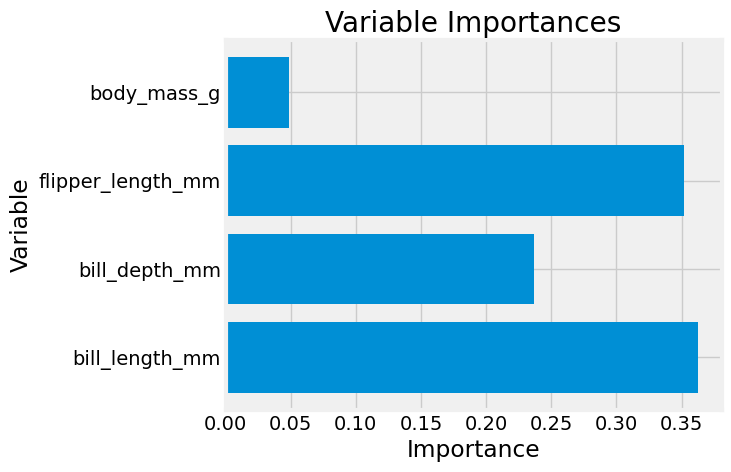

In [12]:
def calc_importances(rf, feature_list):
    ''' Calculate feature importance '''
    # Get numerical feature importances
    importances = list(rf.feature_importances_)

    # List of tuples with variable and importance
    feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

    # Sort the feature importances by most important first
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

    # Print out the feature and importances 
    print('')
    [print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]
    print('')

    return importances

def plot_feat_importances(importances, feature_list):
    ''' Plot the feature importance calculated by calc_importances ''' 
    plt.figure()
    # Set the style
    plt.style.use('fivethirtyeight')
    # list of x locations for plotting
    x_values = list(range(len(importances)))
    # Make a bar chart
    plt.barh(x_values, importances)
    # Tick labels for x axis
    plt.yticks(x_values, feature_list)
    # Axis labels and title
    plt.xlabel('Importance'); plt.ylabel('Variable'); plt.title('Variable Importances')
    
    
plot_feat_importances(calc_importances(forest, feature_names),  feature_names)

## 3.3. Permutation importance

Permutation importance shows which features cause the largest drop in skill if they are randomly shuffled.

In [13]:
# Single-pass permutation
permute = permutation_importance(
    forest, X, y, n_repeats=20, random_state=fd["random_state"])

# Sort the importances
sorted_idx = permute.importances_mean.argsort()

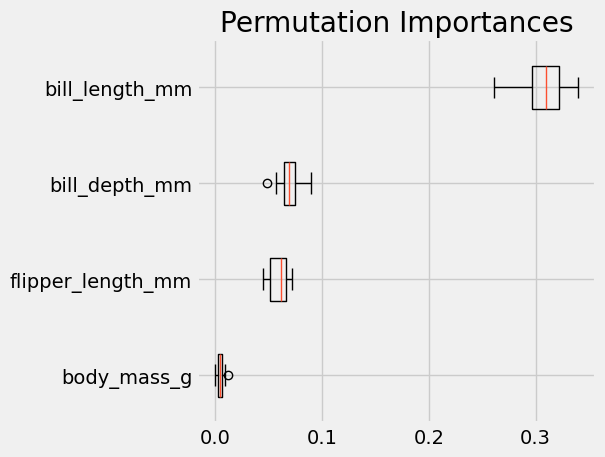

In [14]:
def plot_perm_importances(permute, sorted_idx, feature_list):
    ''' Plot the permutation importances calculated in previous cell '''
    # Sort the feature list based on 
    new_feature_list = []
    for index in sorted_idx:  
        new_feature_list.append(feature_list[index])

    fig, ax = plt.subplots()
    ax.boxplot(permute.importances[sorted_idx].T,
           vert=False, labels=new_feature_list)
    ax.set_title("Permutation Importances")
    fig.tight_layout()
    
plot_perm_importances(permute, sorted_idx, feature_names)

# 4. Run random forest classifier on the testing data

In [15]:
raise Exception("you shall not pass.")

Exception: you shall not pass.

Once you're happy with your model and feel ready, run your random forest on the testing data!

In [16]:
y_pred_test = forest.predict(X_test)

acc = metrics.accuracy_score(y_test, y_pred_test)
print("held-back testing accuracy: ", np.around(acc*100), '%')
confusion_matrix(y_test, y_pred_test)

held-back testing accuracy:  96.0 %


array([[45,  2,  0],
       [ 2, 19,  0],
       [ 0,  0, 32]])

🐧